In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json

In [2]:
from types import SimpleNamespace

paths = SimpleNamespace(
    summary="results/rnnprop_{}/summary.csv",
    config="results/rnnprop_{}/config.json",
    evaluation="results/rnnprop_{}/period_19.npz",
    baseline="results/adam.json")

In [3]:
full_names = {
    "base": "switch(IL, ML)",
    "metaonly": "ML only",
    "2t": "switch((IL1 + IL2)/2, ML)",
    "2t_max": "switch(max(IL1, IL2), ML)",
    "ilsum": "a * IL + ML",
    "ilsum_reweight": "0.25a * IL + ML",
    "ilsum_2t": "a * max(IL1, IL2) + ML"
}

colors = {
    "adam": "tab:red",
    "base": "tab:blue",
    "metaonly": "tab:brown",
    "2t": "tab:purple",
    "2t_max": "tab:green",
    "ilsum": "tab:orange",
    "ilsum_reweight": "tab:pink",
    "ilsum_2t": "tab:cyan"
}

tests_all = ["adam", "metaonly", "base", "2t_max", "2t", "ilsum", "ilsum_reweight", "ilsum_2t"]
tests_best = ["adam", "base", "2t_max", "ilsum", "ilsum_2t"]
keys = ["loss", "val_loss", "sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]

In [4]:
def moving_average(a, n=10):
    """Moving average utility with truncated averages for the tails.
    
    Parameters
    ----------
    a : np.array
        Array input. Should be one dimensional.
    n : int
        Moving average window.
    """
    # Center
    cs = np.cumsum(a, dtype=float)
    cs[n:] = cs[n:] - cs[:-n]
    center = cs[n - 1:] / n

    # Tails
    left = np.cumsum(a[:int(n / 2)]) / np.arange(1, 1 + int(n / 2))
    right = np.flip(
        np.cumsum(a[-int(n / 2):][::-1]) / np.arange(1, 1 + int(n / 2)))
    return np.concatenate([left, center, right])


def plot_band(ax, x, y, label=None, color=None):
    """Plot mean and min-to-max color band for stacked data y."""
    lower, upper, mean = [f(y, axis=0) for f in [np.min, np.max, np.mean]]
    mean_line, = ax.plot(x, mean, label=label, color=color)
    ax.fill_between(x, lower, upper, alpha=0.25, color=mean_line.get_color())
    return mean_line

In [5]:
def plot_stats(tests, axs):
    
    for key in tests:
        d = np.load("results/baseline_adam.npz" if key == "adam" else paths.evaluation.format(key)) 
        for ax, val in zip([*axs[0], *axs[1]], keys):
            y_val = np.log(d[val]) if val.endswith("loss") else d[val]
            plot_band(
                ax, np.arange(20), y_val,
                label="Adam" if key == "adam" else full_names[key],
                color=colors[key])

    for ax in [*axs[0], *axs[1]]:
        ax.set_xticks(np.arange(20))
        ax.set_xlabel("Epoch")

    axs[1][1].legend()

    axs[0][0].set_ylabel("Log Training Loss")
    axs[0][1].set_ylabel("Log Validation Loss")
    axs[1][0].set_ylabel("Training Accuracy")
    axs[1][1].set_ylabel("Validation Accuracy")


In [6]:
def plot_phase(tests, ax):
    for t in tests:
        d = np.load("results/baseline_adam.npz" if t == "adam" else paths.evaluation.format(t))
        x = np.mean(d["sparse_categorical_accuracy"], axis=0)
        y = np.mean(d["val_sparse_categorical_accuracy"], axis=0)
        label = "Adam" if t == "adam" else full_names[t]
        ax.quiver(
            x[:-1], y[:-1], x[1:] - x[:-1], y[1:] - y[:-1],
            width=0.002, headwidth=5, headlength=5, color=colors[t],
            scale_units="xy", angles="xy", scale=1, label=label)
    ax.legend()
    ax.set_xlabel("Train Accuracy")
    ax.set_ylabel("Validation Accuracy")

def plot_phase_loss(tests, ax):
    for t in tests:
        d = np.load("results/baseline_adam.npz" if t == "adam" else paths.evaluation.format(t))
        x = np.log(np.mean(d["loss"], axis=0))
        y = np.log(np.mean(d["val_loss"], axis=0))
        label = "Adam" if t == "adam" else full_names[t]
        ax.quiver(
            x[:-1], y[:-1], x[1:] - x[:-1], y[1:] - y[:-1],
            width=0.002, headwidth=5, headlength=5, color=colors[t],
            scale_units="xy", angles="xy", scale=1, label=label)
    ax.legend()
    ax.set_xlabel("Log Train Loss")
    ax.set_ylabel("Log Validation Loss")


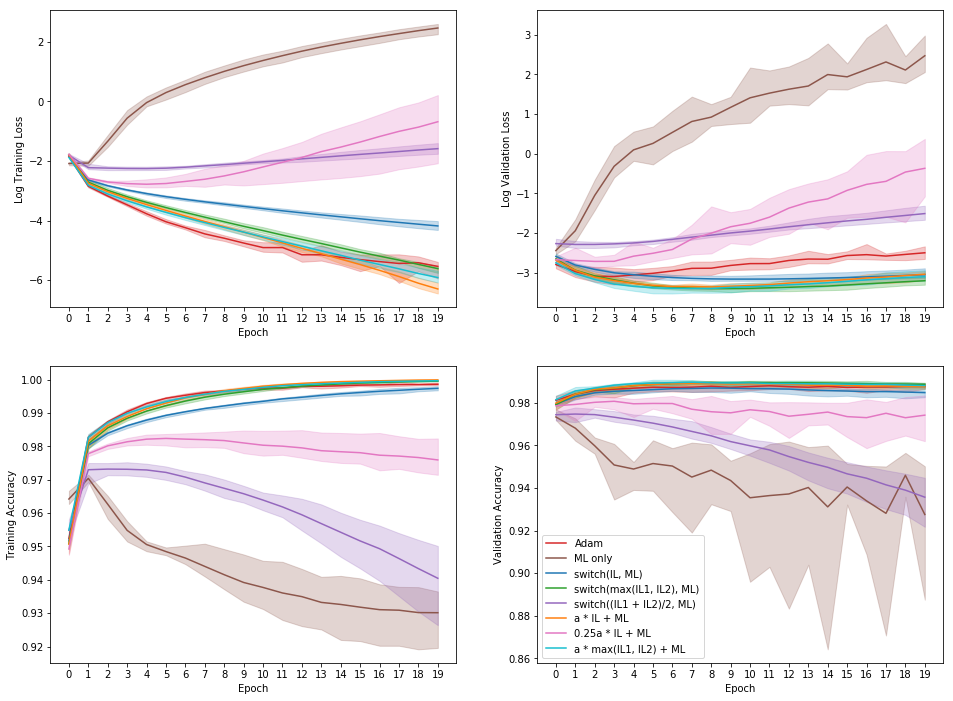

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
plot_stats(tests_all, axs)

(0.977, 0.991)

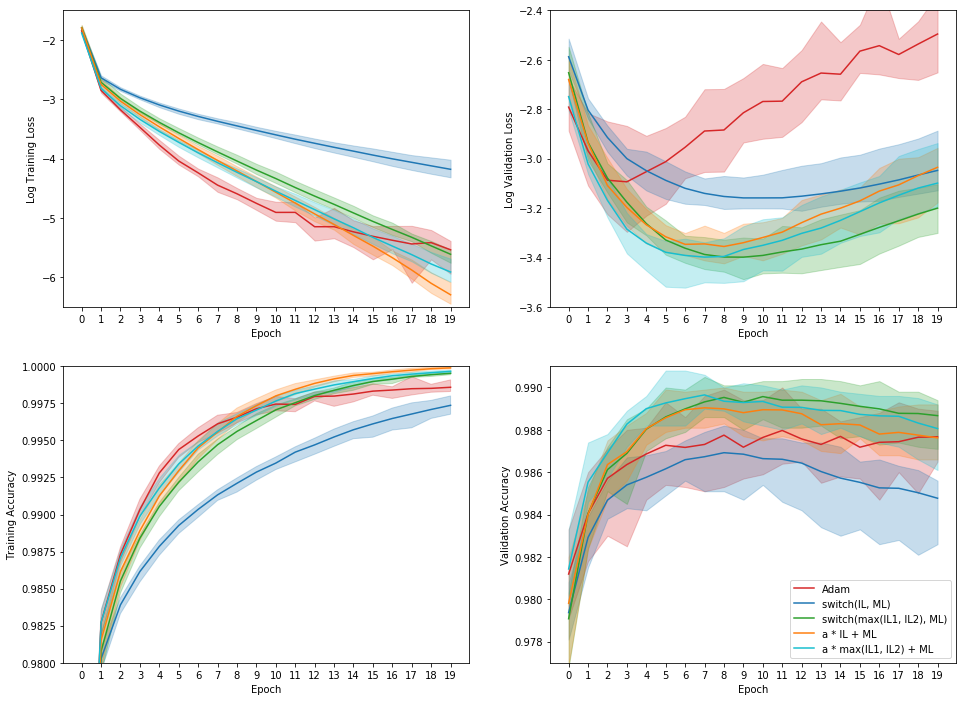

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
plot_stats(tests_best, axs)
axs[0][0].set_ylim(-6.5, -1.5)
axs[0][1].set_ylim(-3.6, -2.4)
axs[1][0].set_ylim(0.98, 1)
axs[1][1].set_ylim(0.977, 0.991)


(0.0, 0.014)

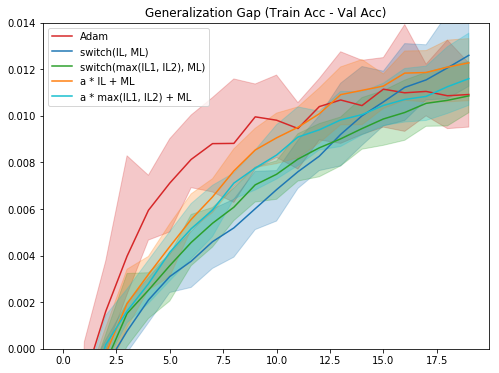

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(8, 6))

for key in tests_best:
    d = np.load("results/baseline_adam.npz" if key == "adam" else paths.evaluation.format(key))

    plot_band(
        axs, np.arange(20),
        d["sparse_categorical_accuracy"] - d["val_sparse_categorical_accuracy"],
        label="Adam" if key == "adam" else full_names[key],
        color=colors[key])

axs.legend()
axs.set_title("Generalization Gap (Train Acc - Val Acc)")
axs.set_ylim(0.0, 0.014)

(-3.45, -2.8)

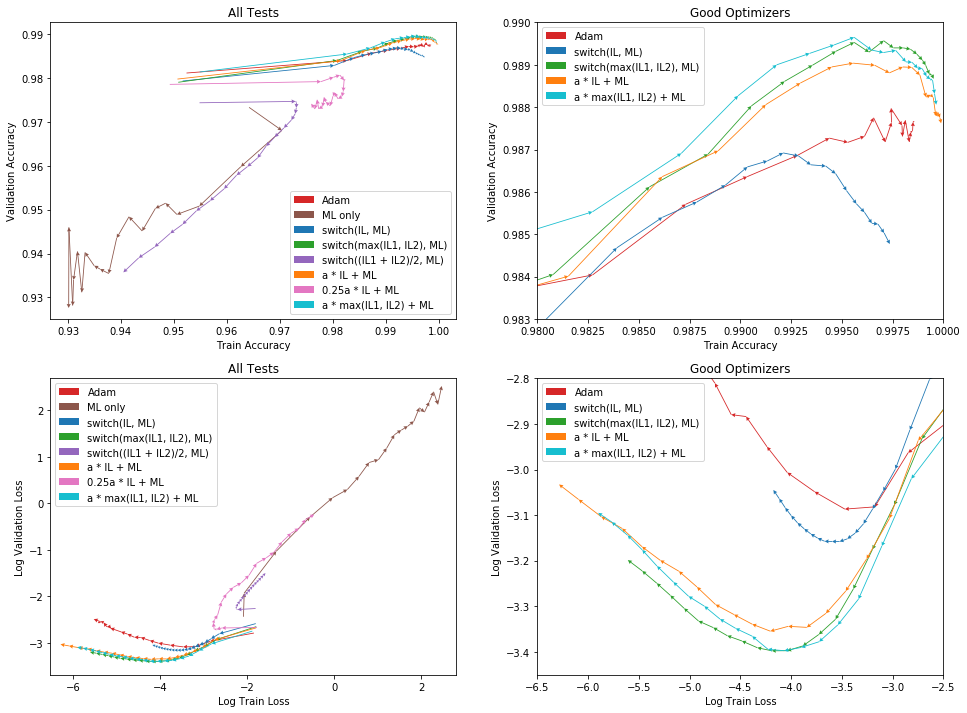

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
# fig.suptitle("Generalization: (train, val) Trajectories")

for row, pf in zip(axs, [plot_phase, plot_phase_loss]):
    pf(tests_all, row[0])
    row[0].set_title("All Tests")
    pf(tests_best, row[1])
    row[1].set_title("Good Optimizers")


axs[0][1].set_xlim(0.980, 1.00)
axs[0][1].set_ylim(0.983, 0.99)

axs[1][1].set_xlim(-6.5, -2.5)
axs[1][1].set_ylim(-3.45, -2.8)

(0.981, 0.991)

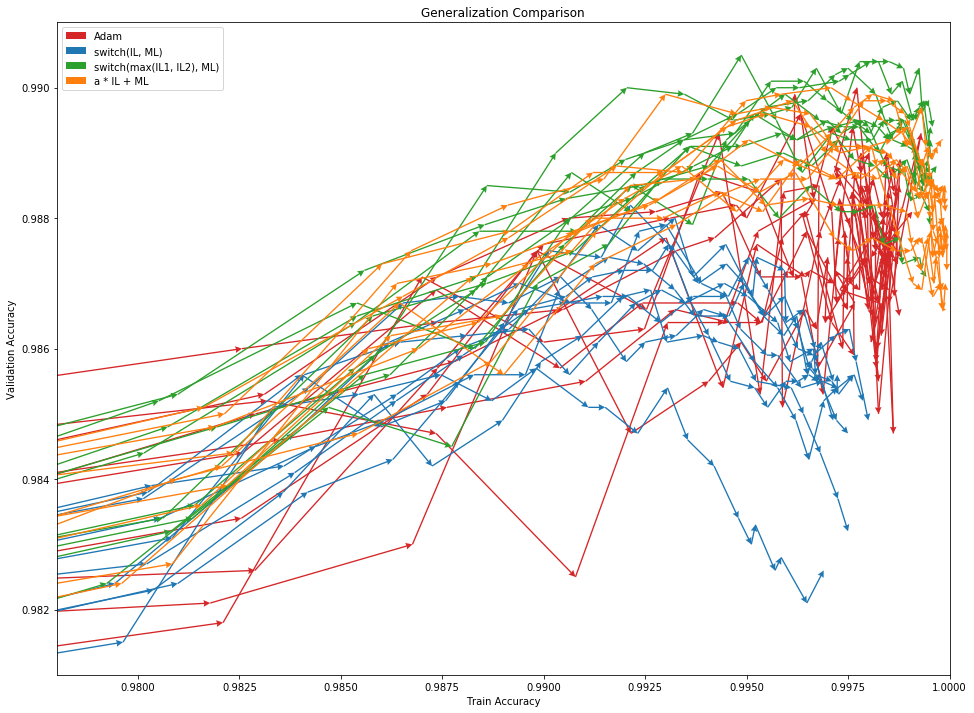

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(16, 12))

for key in ["adam", "base", "2t_max", "ilsum"]:
    d = np.load("results/baseline_adam.npz" if key == "adam" else paths.evaluation.format(key))

    x = np.mean(d["sparse_categorical_accuracy"], axis=0)
    y = np.mean(d["val_sparse_categorical_accuracy"], axis=0)
    label = "Adam" if key == "adam" else full_names[key]

    draw_label = True
    for x, y in zip(d["sparse_categorical_accuracy"], d["val_sparse_categorical_accuracy"]):

        axs.quiver(
            x[:-1], y[:-1], x[1:] - x[:-1], y[1:] - y[:-1],
            width=0.0015, headwidth=5, headlength=5, color=colors[key],
            scale_units="xy", angles="xy", scale=1, label=label if draw_label else None)
        draw_label = False

axs.legend()
axs.set_xlabel("Train Accuracy")
axs.set_ylabel("Validation Accuracy")
axs.set_title("Generalization Comparison")
axs.set_xlim(0.978, 1.00)
axs.set_ylim(0.981, 0.991)

In [12]:
    for i in [15, 16, 17, 18, 19, 20]:
        d = np.load("results/rnnprop_base_1/period_{}.npz".format(i)) 
        for ax, val in zip([*axs[0], *axs[1]], keys):
            y_val = np.log(d[val]) if val.endswith("loss") else d[val]
            plot_band(
                ax, np.arange(20), y_val,
                label=str(i))

    for ax in [*axs[0], *axs[1]]:
        ax.set_xticks(np.arange(20))
        ax.set_xlabel("Epoch")

    axs[1][1].legend()

    axs[0][0].set_ylabel("Log Training Loss")
    axs[0][1].set_ylabel("Log Validation Loss")
    axs[1][0].set_ylabel("Training Accuracy")
    axs[1][1].set_ylabel("Validation Accuracy")

BadZipFile: File is not a zip file